     age      fare  fare_roll5
0   0.42    8.5167    8.516700
1   0.67   14.5000   11.508350
2   0.75   19.2583   14.091667
3   0.75   19.2583   15.383325
4   0.83   29.0000   18.106660
5   0.83   18.7500   20.153320
6   0.92  151.5500   47.563320
7   1.00   46.9000   53.091660
8   1.00   11.1333   51.466660
9   1.00   39.0000   53.466660
10  1.00   39.6875   57.654160
11  1.00   37.0042   34.745000


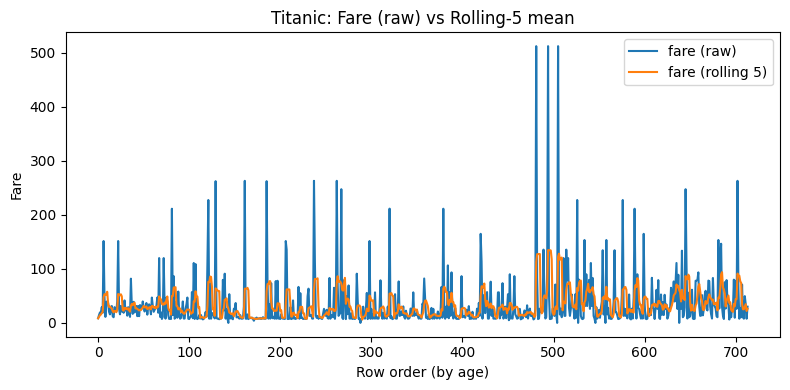


Matches preview:
    match_id   season    stage                 team             opponent  goals_for  goals_against result  points
0         1  2021/22    Group      Manchester City  Paris Saint-Germain          3              1    Win       3
1         2  2021/22    Group          Real Madrid           Chelsea FC          2              1    Win       3
2         3  2021/22    Group    FC Bayern München         Liverpool FC          1              3   Loss       0
3         4  2021/22  Quarter             AC Milan          Real Madrid          0              2   Loss       0
4         5  2021/22  Quarter  Paris Saint-Germain    FC Bayern München          2              2   Draw       1
5         6  2021/22     Semi           Chelsea FC      Manchester City          1              0    Win       3

Standings with rank (sort + cumcount):
      season                 team  matches  points  gf  ga  gd  rank
3   2021/22      Manchester City        1       3   3   1   2     1
5   2021/22  

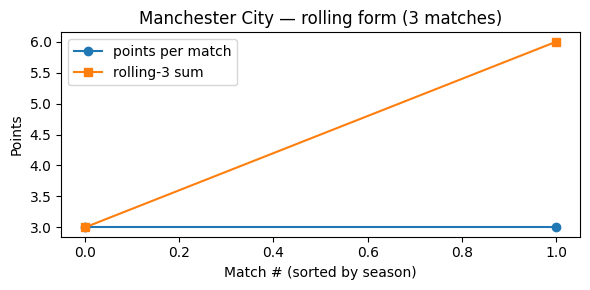

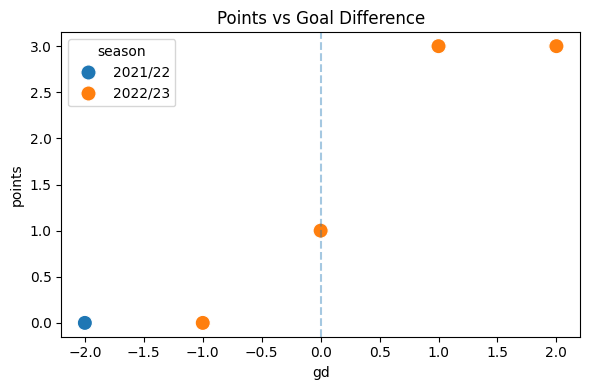

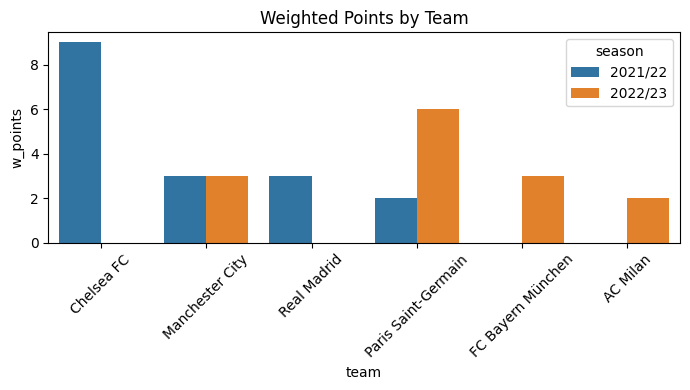

In [9]:
# === RECAP — Rolling, Ranking, Weighted Points ===
# You’ll run this in order, one section at a time.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.width", 160)
pd.set_option("display.max_rows", 80)

# --------------------------------------------------
# PART A — Rolling stats (Titanic fare)
# --------------------------------------------------
import seaborn as sns
titanic = sns.load_dataset("titanic").copy()

# Keep only columns we use; drop rows that would break rolling calc
titanic = titanic[["age","fare"]].dropna()

# Sort is good hygiene for time-like operations (here age is continuous, we’ll use it as “order”)
titanic = titanic.sort_values("age").reset_index(drop=True)

# Rolling mean over the last 5 rows (window=5)
# min_periods=1 means "start computing as soon as at least 1 row exists"

titanic["fare_roll5"] = (titanic["fare"]
                         .rolling(window=5,min_periods=1)
                         .mean())

print(titanic[["age","fare","fare_roll5"]].head(12))

# Quick visualization: actual vs smoothed
plt.figure(figsize=(8,4))
plt.plot(titanic["fare"].values, label="fare (raw)")
plt.plot(titanic["fare_roll5"].values, label="fare (rolling 5)")
plt.title("Titanic: Fare (raw) vs Rolling-5 mean")
plt.xlabel("Row order (by age)"); plt.ylabel("Fare")
plt.legend(); plt.tight_layout(); plt.show()

# --------------------------------------------------
# PART B — Build a tiny matches dataset (two seasons)
# --------------------------------------------------
matches = pd.DataFrame({
    "match_id": np.arange(1, 13),
    "season":    ["2021/22"]*6 + ["2022/23"]*6,
    "stage":     ["Group","Group","Group","Quarter","Quarter","Semi"]*2,
    "team": [
        "Manchester City","Real Madrid","FC Bayern München","AC Milan","Paris Saint-Germain","Chelsea FC",
        "Manchester City","Real Madrid","FC Bayern München","AC Milan","Paris Saint-Germain","Chelsea FC"
    ],
    "opponent": [
        "Paris Saint-Germain","Chelsea FC","Liverpool FC","Real Madrid","FC Bayern München","Manchester City",
        "Paris Saint-Germain","Chelsea FC","Liverpool FC","Real Madrid","FC Bayern München","Manchester City"
    ],
    "goals_for":     [3,2,1,0,2,1,  4,1,2,1,3,2],
    "goals_against": [1,1,3,2,2,0,  2,2,1,1,1,3]
})

# Result per match (vectorized IF/ELSE)
matches["result"] = np.select(
    [matches["goals_for"] > matches["goals_against"],
     matches["goals_for"] < matches["goals_against"]],
    ["Win","Loss"],
    default="Draw"
)

# Points per match: Win=3, Draw=1, Loss=0
matches["points"] = np.select(
    [matches["result"].eq("Win"),matches["result"].eq("Draw")],
    [3,1], default=0
)

print("\nMatches preview:\n", matches.head(6))

# --------------------------------------------------
# PART C — Ranking (two approaches)
# --------------------------------------------------
# 1) League-style: sort with explicit tiebreakers, then assign 1..N

standings = (matches
             .groupby(["season","team"], as_index=False)
             .agg(
                 matches=("match_id","count"),
                 points=("points","sum"),
                 gf=("goals_for","sum"),
                 ga=("goals_against","sum")
             ))
standings["gd"] = standings["gf"] - standings["ga"]

# Sort by season asc, then points desc, gd desc, gf desc
standings_sorted = (
    standings.sort_values(["season","points","gd","gf"], ascending=[True,False,False,False])
    .assign(rank=lambda d: d.groupby("season").cumcount()+1)
)

print("\nStandings with rank (sort + cumcount):\n", standings_sorted)

# 2) Pure rank on a single metric (or composite) using .rank()
# Note: rank() returns floats; method='dense' collapses ties (1,1,2,2,3…)
standings_rank = standings.copy()
standings_rank["rank_points"] = (
    standings_rank.groupby("season")["points"].rank(method="dense", ascending=False)
)


print("\nRank via .rank() only (points), and (points+gd combo):\n", standings_rank[["season","team","points","gd","rank_points"]])


# --------------------------------------------------
# PART D — Weighted points (by stage)
# --------------------------------------------------
stages_meta = pd.DataFrame({
    "stage": ["Group","Quarter","Semi","Final"],
    "stage_weight": [1, 2, 3, 4]   # toy weights to emphasize later rounds
})

# Join stage weights onto each match
with_w = matches.merge(stages_meta, on="stage", how="left").fillna({"stage_weight":1})

# Weighted points per match
with_w["weighted_points"] = with_w["points"] * with_w["stage_weight"]

weighted_table = (
    with_w.groupby(["season","team"], as_index=False)
          .agg(
              matches=("match_id","count"),
              points=("points","sum"),
              w_points=("weighted_points","sum"),
              gf=("goals_for","sum"),
              ga=("goals_against","sum")
          )
          .assign(gd=lambda d: d["gf"] - d["ga"])
          .sort_values(["season","w_points","gd","gf"], ascending=[True, False, False, False])
)
print("\nWeighted standings:\n", weighted_table)


# --------------------------------------------------
# PART E — Rolling form per team (last 3 matches)
# --------------------------------------------------
# Sort by team then season to simulate “time”
matches_timed = matches.sort_values(["team","season"]).reset_index(drop=True)

# Convert per-match result to per-match points again (explicit)
matches_timed["pts"] = np.select(
    [matches_timed["result"].eq("Win"), matches_timed["result"].eq("Draw")],
    [3,1], default=0
)

# Rolling sum of points over last 3 matches, per team
matches_timed["form3"] = (
    matches_timed
    .groupby("team", group_keys=False)["pts"]
    .rolling(window=3, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)

print("\nRolling form (3-match points):\n", matches_timed[["team","season","pts","form3"]].head(12))

# Optional quick plot for one team (e.g., Manchester City)
mc = matches_timed[matches_timed["team"]=="Manchester City"].reset_index(drop=True)
plt.figure(figsize=(6,3))
plt.plot(mc["pts"], marker="o", label="points per match")
plt.plot(mc["form3"], marker="s", label="rolling-3 sum")
plt.title("Manchester City — rolling form (3 matches)")
plt.xlabel("Match # (sorted by season)"); plt.ylabel("Points")
plt.legend(); plt.tight_layout(); plt.show()


# --------------------------------------------------
# PART F — Two small visuals to lock it in
# --------------------------------------------------
# 1) Points vs GD scatter (who’s efficient?)
plt.figure(figsize=(6,4))
sns.scatterplot(data=standings_sorted, x="gd", y="points", hue="season", s=120)
plt.axvline(0, ls="--", alpha=0.4)
plt.title("Points vs Goal Difference"); plt.tight_layout(); plt.show()

# 2) Weighted points bar
plt.figure(figsize=(7,4))
sns.barplot(data=weighted_table, x="team", y="w_points", hue="season")
plt.xticks(rotation=45); plt.title("Weighted Points by Team"); plt.tight_layout(); plt.show()










